In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob 
from wordcloud import WordCloud 

In [4]:
df = pd.read_csv('Student_Satisfaction_Survey.csv',encoding = 'latin1') 
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SN                    580 non-null    int64 
 1   Total Feedback Given  580 non-null    int64 
 2   Total Configured      580 non-null    int64 
 3   Questions             580 non-null    object
 4   Weightage 1           580 non-null    int64 
 5   Weightage 2           580 non-null    int64 
 6   Weightage 3           580 non-null    int64 
 7   Weightage 4           580 non-null    int64 
 8   Weightage 5           580 non-null    int64 
 9   Average/ Percentage   580 non-null    object
 10  Course Name           580 non-null    object
 11  Basic Course          580 non-null    object
dtypes: int64(8), object(4)
memory usage: 54.5+ KB
None


,SN,Total Feedback Given,Total Configured,Questions,Weightage 1,Weightage 2,Weightage 3,Weightage 4,Weightage 5,Average/ Percentage,Course Name,Basic Course
0,1,1,12,How much of the syllabus was covered in the cl...,0,0,1,0,0,3.00 / 60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
1,2,1,12,How well did the teachers prepare for the clas...,0,0,0,0,1,5.00 / 100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
2,3,1,12,How well were the teachers able to communicate?,0,0,0,0,1,5.00 / 100.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
3,4,1,12,The teachers approach to teaching can best be...,0,0,1,0,0,3.00 / 60.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY
4,5,1,12,Fairness of the internal evaluation process by...,0,0,0,1,0,4.00 / 80.00,FY B.VOC FOOD TECHNOLOGY,B.VOC FOOD TECHNOLOGY


In [6]:
print(f"Duplicates: {df.duplicated().sum()}")
df['Average/ Percentage'] = df['Average/ Percentage'].apply(lambda x: float(x.split('/')[0].strip()))

print("Sample of cleaned 'Average/ Percentage':")
display(df['Average/ Percentage'].head())

df['Calculated Total'] = df['Weightage 1'] + df['Weightage 2'] + df['Weightage 3'] + df['Weightage 4'] + df['Weightage 5']
print("Mismatch in totals:", (df['Calculated Total'] != df['Total Feedback Given']).sum())

df = df.drop('Calculated Total', axis=1)

Duplicates: 0
Sample of cleaned 'Average/ Percentage':


0    3.0
1    5.0
2    5.0
3    3.0
4    4.0
Name: Average/ Percentage, dtype: float64

Mismatch in totals: 0


In [9]:
df['Weighted Average'] = (1*df['Weightage 1'] + 2*df['Weightage 2'] + 3*df['Weightage 3'] + 4*df['Weightage 4'] + 5*df['Weightage 5']) / df['Total Feedback Given']

print("Difference between Weighted Average and Average/ Percentage:")
print((df['Weighted Average'] - df['Average/ Percentage']).abs().describe())

course_stats = df.groupby('Course Name ').agg({
    'Weighted Average': 'mean',
    'Total Feedback Given': 'sum'
}).rename(columns={'Weighted Average': 'Overall Average Rating'})
course_stats = course_stats.sort_values('Overall Average Rating', ascending=False)

print("Top 3 Courses by Average Rating:")
display(course_stats.head(3))
print("Bottom 3 Courses by Average Rating:")
display(course_stats.tail(3))

question_stats = df.groupby('Questions')['Weighted Average'].mean().sort_values()
print("Lowest Rated Questions:")
display(question_stats.head(5))

Difference between Weighted Average and Average/ Percentage:
count    580.000000
mean       0.001635
std        0.001676
min        0.000000
25%        0.000000
50%        0.001429
75%        0.003333
max        0.004872
dtype: float64
Top 3 Courses by Average Rating:


,Overall Average Rating,Total Feedback Given
Course Name,,
FYBA,4.550000,20
MSC ANALYTICAL CHEMISTRY SEM I,4.525000,40
TYBSC,4.522222,180


Bottom 3 Courses by Average Rating:


,Overall Average Rating,Total Feedback Given
Course Name,,
SY COMPUTER SCIENCE,3.353704,540
SYBSC,3.221429,140
MSC DATA SCIENCE - 1,2.733333,60


Lowest Rated Questions:


Questions
The teaching and mentoring process in your institution facilitates you in cognitive, social and\nemotional growth.            3.578913
What percentage of teachers use ICT tools such as LCD projectors, Multimedia, etc. while teaching?                            3.584090
The teachers identify your strengths and encourage you to provide the proper level of challenges.                             3.615221
The institute takes an active interest in promoting internships, student exchange, field visit opportunities for students.    3.618758
Teachers are able to identify your weaknesses and help you to overcome them.                                                  3.704001
Name: Weighted Average, dtype: float64

In [8]:
# Print all column names to verify
print("Column names in DataFrame:")
print(df.columns.tolist())

Column names in DataFrame:
['SN', 'Total Feedback Given', 'Total Configured', 'Questions', 'Weightage 1', 'Weightage 2', 'Weightage 3', 'Weightage 4', 'Weightage 5', 'Average/ Percentage', 'Course Name ', 'Basic Course', 'Weighted Average']


In [10]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df[['Polarity', 'Subjectivity']] = df['Questions'].apply(get_sentiment).apply(pd.Series)

sentiment_summary = df.groupby('Questions').agg({'Polarity': 'mean', 'Subjectivity': 'mean'}).sort_values('Polarity')
print("Sentiment Summary (on Question Text):")
display(sentiment_summary)

overall_polarity = df['Polarity'].mean()
print(f"Overall Question Sentiment Polarity: {overall_polarity:.3f} ({'Positive' if overall_polarity > 0 else 'Negative' if overall_polarity < 0 else 'Neutral'})")

Sentiment Summary (on Question Text):


,Polarity,Subjectivity
Questions,,
"The institute takes an active interest in promoting internships, student exchange, field visit opportunities for students.",-0.133333,0.600000
"Teachers inform you about your expected competencies, course outcomes and program\noutcomes.",-0.100000,0.400000
"The institute/ teachers use student-centric methods, such as experiential learning, participative learning and problem-solving methodologies for enhancing learning experiences.",0.000000,0.500000
Was your performance in assignments discussed with you?,0.000000,0.000000
The teachers illustrate the concepts through examples and applications.,0.000000,0.000000
The teachers identify your strengths and encourage you to provide the proper level of challenges.,0.000000,0.100000
The institution provides multiple opportunities to learn and grow.,0.000000,0.000000
"The institution makes effort to engage students in the monitoring, review and continuous quality improvement of the teaching-learning process.",0.000000,0.000000
"What percentage of teachers use ICT tools such as LCD projectors, Multimedia, etc. while teaching?",0.000000,0.500000


Overall Question Sentiment Polarity: 0.129 (Positive)


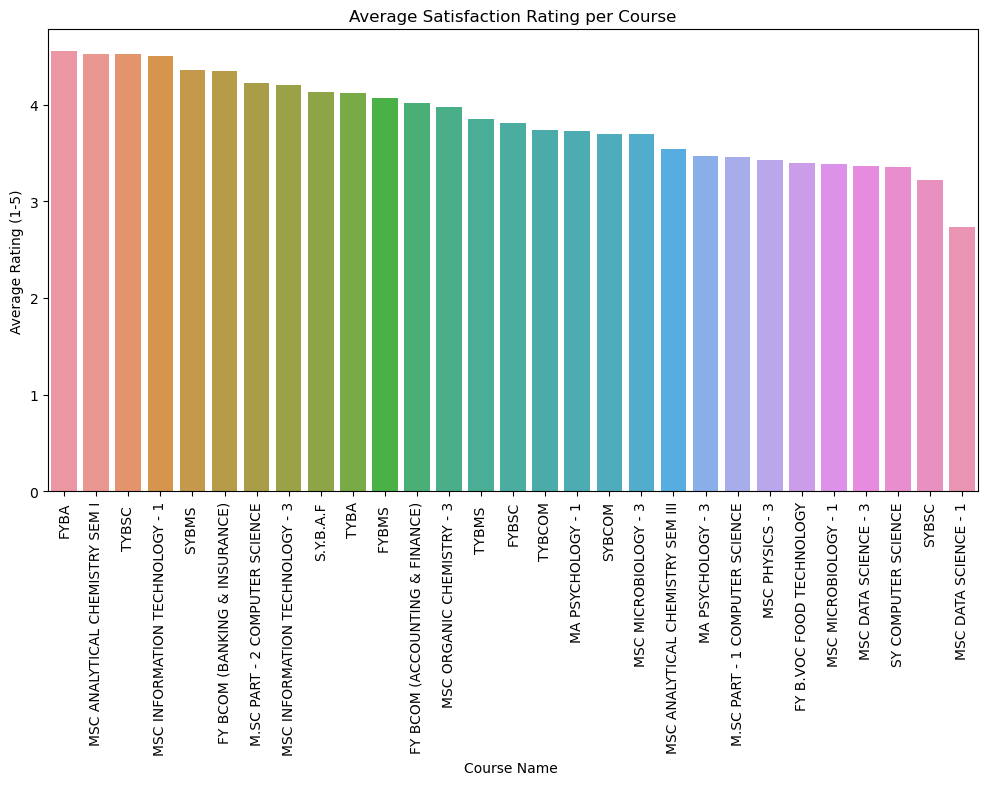

In [12]:
plt.figure(figsize=(12, 6))
sns.barplot(x=course_stats.index, y='Overall Average Rating', data=course_stats)
plt.xticks(rotation=90)
plt.title('Average Satisfaction Rating per Course')
plt.ylabel('Average Rating (1-5)')
plt.show()





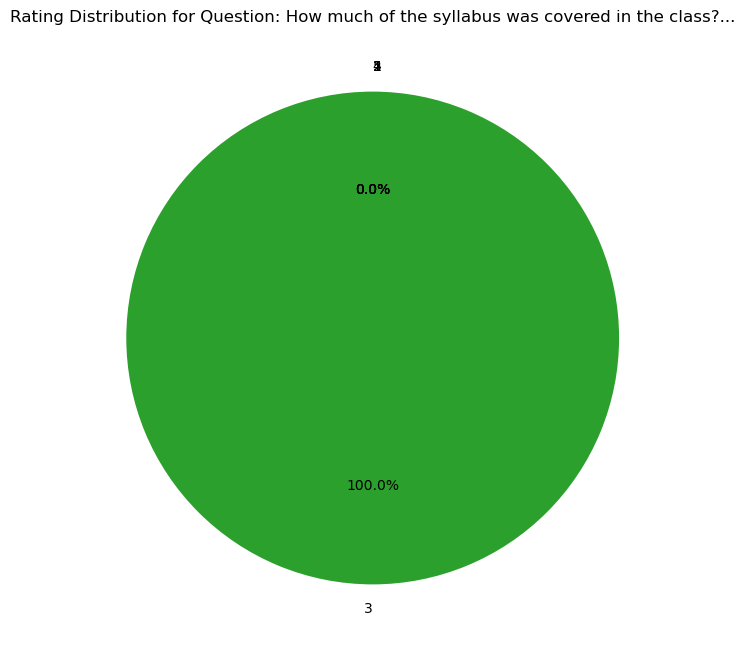

In [13]:
sample_question = df.iloc[0]
ratings = [sample_question['Weightage 1'], sample_question['Weightage 2'], sample_question['Weightage 3'], sample_question['Weightage 4'], sample_question['Weightage 5']]
labels = ['1', '2', '3', '4', '5']
plt.figure(figsize=(8, 8))
plt.pie(ratings, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title(f"Rating Distribution for Question: {sample_question['Questions'][:50]}...")
plt.show()

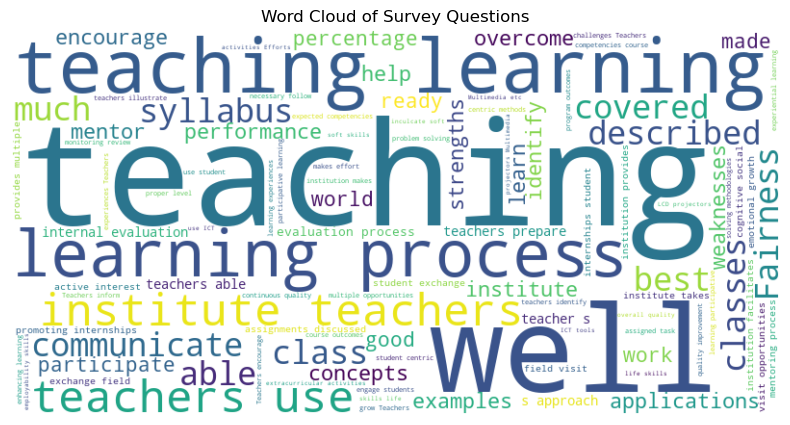

In [14]:
text = ' '.join(df['Questions'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Survey Questions')
plt.show()

In [15]:
print("Correlation between Weighted Average and Feedback Volume:")
print(df[['Weighted Average', 'Total Feedback Given']].corr())

Correlation between Weighted Average and Feedback Volume:
                      Weighted Average  Total Feedback Given
Weighted Average              1.000000              0.070256
Total Feedback Given          0.070256              1.000000
